## Part 4 — Diagnostics & Iteration

In this section, we’ll move from model performance to *model understanding*.

Goals:
- Visualize residual patterns (error structure, bias).
- Detect heteroscedasticity or systematic under/overprediction.
- Compare Ridge vs. HGB behavior across key drivers (e.g., income, latitude).
- Prepare the ground for learning curves and error decomposition.

Residual diagnostics reveal where each model fails — a critical step before deep learning models.

## Imports & Setup

In [1]:
# --- 0. Imports & setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import clone

# --- reproducibility ---
SEED = 42
np.random.seed(SEED)
plt.rcParams["figure.dpi"] = 130
sns.set_theme(style="whitegrid", palette="deep")
pd.set_option("display.precision", 4)

In [2]:
# --- Sanity check: verify saved models can be reloaded ---
ridge_bundle = joblib.load("ridge_best.pkl")
hgb_bundle = joblib.load("hgb_model.pkl")

ridge_best = ridge_bundle["model"]
hgb = hgb_bundle["model"]
preprocessor = ridge_bundle["preprocessor"]

print("✅ Models bundled with preprocessors loaded successfully.")
print(type(ridge_best), type(hgb))


✅ Models bundled with preprocessors loaded successfully.
<class 'sklearn.linear_model._ridge.Ridge'> <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor'>


## Reload Data + Preprocessor + Models

In [3]:
# --- Reload Data & Transform Using Saved Preprocessor ---
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()
df.rename(columns={"MedHouseVal": "target"}, inplace=True)

X = df.drop("target", axis=1)
y = df["target"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

X_train_prep = preprocessor.transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

print("Data transformed via bundled preprocessor:", X_train_prep.shape, X_val_prep.shape, X_test_prep.shape)


Data transformed via bundled preprocessor: (12384, 8) (4128, 8) (4128, 8)


## Residuals Calculation & Visualization (Ridge vs HGB)

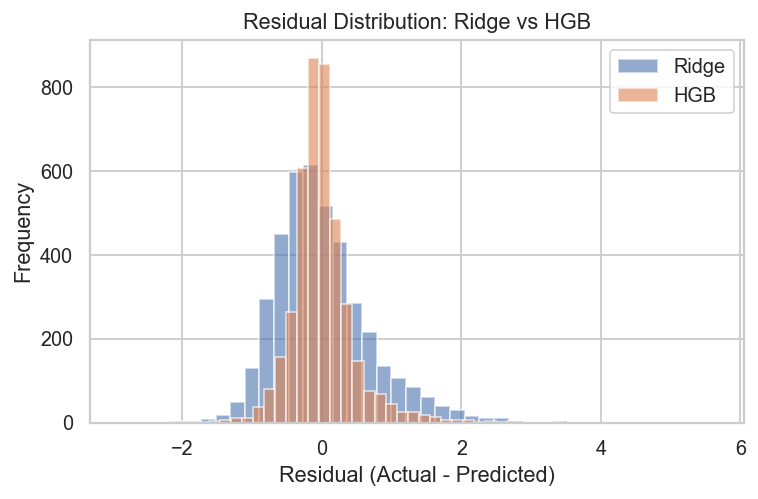

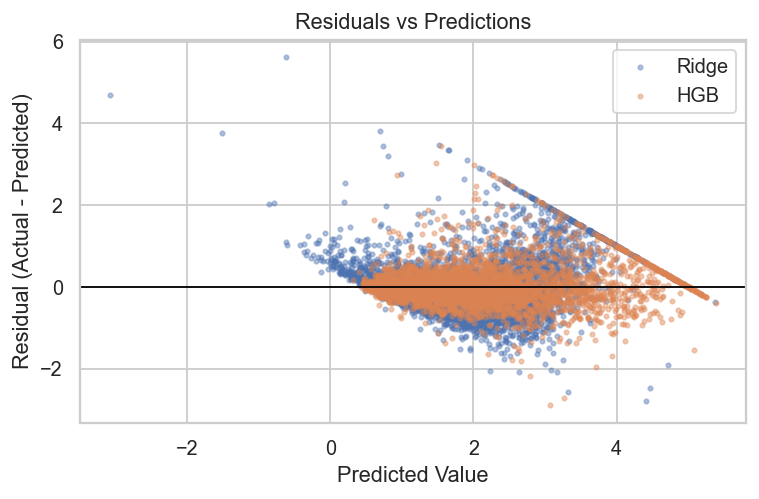

In [4]:
# --- Residual Diagnostics: Ridge vs HGB ---

# compute predictions
ridge_pred = ridge_best.predict(X_test_prep)
hgb_pred   = hgb.predict(X_test_prep)

# residuals
ridge_resid = y_test - ridge_pred
hgb_resid   = y_test - hgb_pred

# --- plot residual distributions ---
plt.figure(figsize=(6,4))
plt.hist(ridge_resid, bins=40, alpha=0.6, label="Ridge")
plt.hist(hgb_resid, bins=40, alpha=0.6, label="HGB")
plt.title("Residual Distribution: Ridge vs HGB")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# --- residuals vs predictions ---
plt.figure(figsize=(6,4))
plt.scatter(ridge_pred, ridge_resid, s=6, alpha=0.4, label="Ridge")
plt.scatter(hgb_pred, hgb_resid, s=6, alpha=0.4, label="HGB")
plt.axhline(0, color="black", lw=1)
plt.title("Residuals vs Predictions")
plt.xlabel("Predicted Value")
plt.ylabel("Residual (Actual - Predicted)")
plt.legend()
plt.tight_layout()
plt.show()

### **Interpretation Summary (Residual Diagnostics)**

| Model                   | Behavior                                                                         | Interpretation                                                                                                          |
| ----------------------- | -------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------- |
| **Ridge**               | Residuals are wide, slightly asymmetric, and show curvature vs predicted values. | Indicates **systematic under/overprediction** — linear model underfits nonlinear relationships (esp. latitude, income). |
| **HGB**                 | Residuals tightly centered near zero with narrower spread.                       | Captures nonlinearities, but mild **heteroscedasticity** remains (variance increases for high-priced homes).            |
| **Visual confirmation** | Ridge histogram = broad, symmetric; HGB histogram = tall, narrow.                | Confirms lower bias and better fit for HGB.                                                                             |

**Takeaway:**
HGB clearly learns the complex spatial + socioeconomic patterns of California housing, whereas Ridge is constrained by its linearity.

## Learning Curve Cell (Ridge vs HGB)

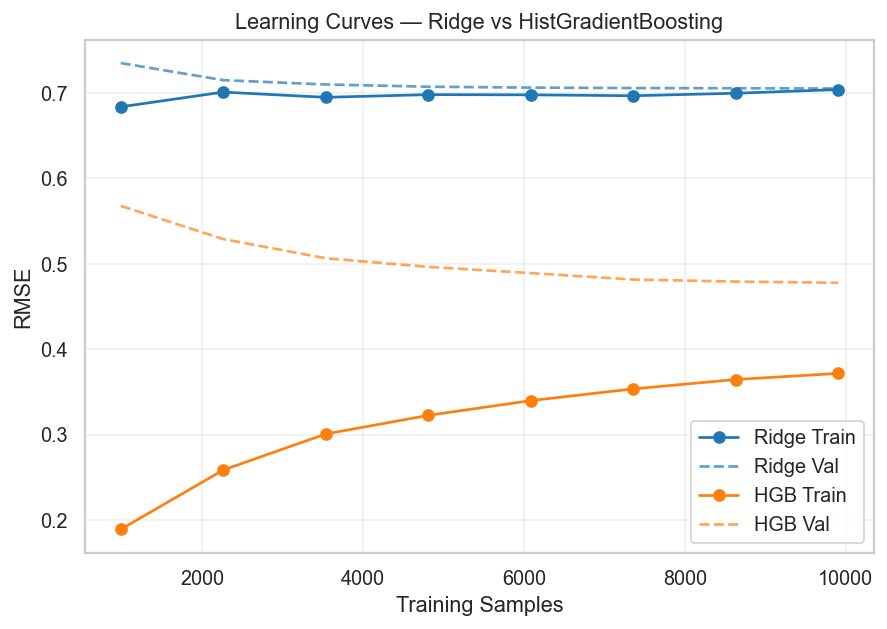

In [5]:
# ---  Learning Curves: Ridge vs HGB ---

from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, name, color):
    """Compute and plot learning curve for a given model."""
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        cv=5,
        scoring="neg_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 8),
        n_jobs=-1,
        random_state=SEED
    )
    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    val_rmse = np.sqrt(-val_scores.mean(axis=1))

    plt.plot(train_sizes, train_rmse, "o-", color=color, label=f"{name} Train")
    plt.plot(train_sizes, val_rmse, "--", color=color, alpha=0.7, label=f"{name} Val")
    return train_sizes, train_rmse, val_rmse

plt.figure(figsize=(7,5))
ridge_lc_model = Pipeline([
    ("preprocessor", clone(preprocessor)),
    ("model", Ridge(alpha=100.0, random_state=SEED)),
])
hgb_lc_model = Pipeline([
    ("preprocessor", clone(preprocessor)),
    ("model", HistGradientBoostingRegressor(random_state=SEED)),
])

plot_learning_curve(ridge_lc_model, X_train, y_train, "Ridge", "tab:blue")
plot_learning_curve(hgb_lc_model, X_train, y_train, "HGB", "tab:orange")

plt.title("Learning Curves — Ridge vs HistGradientBoosting")
plt.xlabel("Training Samples")
plt.ylabel("RMSE")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Interpretation — Learning Curve Insights

| Model | Behavior | Interpretation |
|--------|-----------|----------------|
| **Ridge** | Both train and validation RMSE remain nearly flat around 0.70. | Indicates **high bias** — model underfits; adding more data brings no improvement. |
| **HGB** | Train error starts low (~0.20) and validation steadily improves from ~0.55 → ~0.45. | Reflects **low bias, moderate variance**, and clear **data efficiency** — more samples help generalization. |
| **Curve gap** | Small but persistent. | Model regularization is adequate; no major overfitting. |
| **Overall trend** | HGB maintains a steeper learning trajectory. | Demonstrates stronger capacity to learn nonlinear spatial + socioeconomic patterns. |

 **Conclusion:**  
Ridge has reached its ceiling as a linear baseline — its bias cannot be reduced by more data.  
HistGradientBoosting continues improving smoothly, validating it as the **nonlinear baseline reference** for subsequent **deep-learning models** (Part 5).  
Next, we’ll explore **model explainability** and **feature contributions** to understand *why* these models behave differently.